## Air Quality Dashboard
This notebook shows how to use IPython Widgets to display the air quality using Grove Sensors.

In [1]:
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.animation import FuncAnimation
import collect_air_data
import time
from datetime import datetime
import pandas as pd
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import Button, HBox, VBox

air_data = collect_air_data.collect_air_object()
#Manage relative values of PMS here
pms_ref_0_3 = air_data.pms_ref_0_3
pms_ref_0_5 = air_data.pms_ref_0_5
pms_ref_1_0 = air_data.pms_ref_1_0

In [2]:
#This cell make sure the bme680 is heated up
while True:
    if air_data.bme_680.get_sensor_data():
        output = '{0:.2f} C,{1:.2f} hPa,{2:.2f} %RH'.format(
            air_data.bme_680.data.temperature,
            air_data.bme_680.data.pressure,
            air_data.bme_680.data.humidity)
        #Only print gas data if the heater is stable
        if air_data.bme_680.data.heat_stable:
            print('{0},{1} Ohms'.format(
                output,
                air_data.bme_680.data.gas_resistance))
            break
        else:
            print(output)
    time.sleep(1)

29.00 C,1024.69 hPa,37.29 %RH
29.00 C,1024.69 hPa,37.27 %RH
29.01 C,1024.70 hPa,37.25 %RH
29.02 C,1024.68 hPa,37.23 %RH
29.04 C,1024.68 hPa,37.20 %RH,34084.220559311114 Ohms


In [3]:
air_data.reset_ref_values()
#Reset all the reference values to their current value
pms5003_data = air_data.pms5003.read()
pms_ref_0_3 = pms5003_data.pm_per_1l_air(0.3)
pms_ref_0_5 = pms5003_data.pm_per_1l_air(0.5)
pms_ref_1_0 = pms5003_data.pm_per_1l_air(1.0)

In [4]:
df = pd.DataFrame() #Create an empty data frame to append to later
clean_data_table = pd.DataFrame() #Create an empty data frame to append to later
clean_data_table['Analog Temperature (oC)'] = [air_data.analog_temp()]
clean_data_table['Analog VOC in Air'] = [air_data.analog_voc_ratio()]
clean_data_table['Analog Alcohol in Air'] = [air_data.analog_alcohol_ratio()]
df = df.append(clean_data_table, ignore_index = True)
    
voc_bar = widgets.widgets.FloatProgress(
    value=df.iloc[-1]['Analog VOC in Air'],
    min=0,
    max=1.0,
    description='VOC Air:',
    bar_style='info',
    style={'bar_color': '#fcdb03'},
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)
voc_label = widgets.FloatText(
    value=voc_bar.value,
#    description='Any:',
    disabled=True
)

temp_bar = widgets.widgets.FloatProgress(
    value=df.iloc[-1]['Analog Temperature (oC)'],
    min=0,
    max=36.0,
    description='Temperature:',
    bar_style='info',
    style={'bar_color': '#4ba329'},
    orientation='horizontal'
)

temp_slider = widgets.FloatSlider(
    value=temp_bar.value,
    min=0,
    max=36.0,
    step=0.1,
    description='Test:',
    disabled=True,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)
alcohol_bar = widgets.widgets.FloatProgress(
    value=df.iloc[-1]['Analog Alcohol in Air'],
    min=0,
    max=36.0,
    description='Alcohol:',
    bar_style='info',
    style={'bar_color': '#69fffc'},
    orientation='horizontal'
)

alcohol_label = widgets.FloatText(
    value=alcohol_bar.value,
#    description='Any:',
    disabled=True
)

<IPython.core.display.Javascript object>


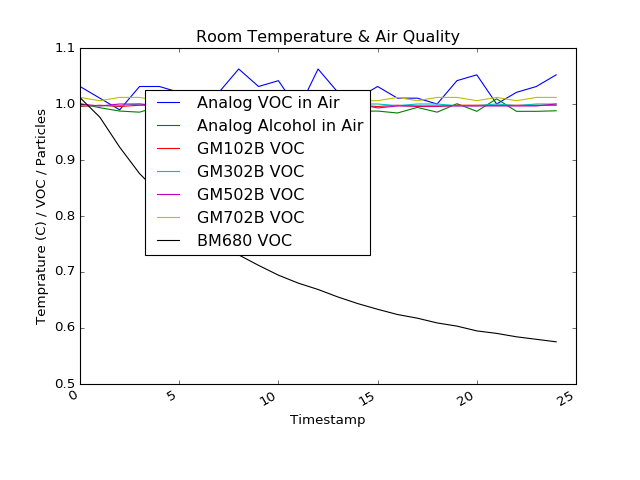

A Jupyter Widget

In [5]:
df = pd.DataFrame() #Create an empty data frame to append to later
def animate(i):
    global df
    clean_data_table = pd.DataFrame() #Create an empty data frame to append to later
    clean_data_table['Analog Temperature (oC)'] = [air_data.analog_temp()]
    clean_data_table['Analog VOC in Air'] = [air_data.analog_voc_ratio()]
    clean_data_table['Analog Alcohol in Air'] = [air_data.analog_alcohol_ratio()]
    clean_data_table['GM102B VOC'] = [air_data.GM102B_ratio()]
    clean_data_table['GM302B VOC'] = [air_data.GM302B_ratio()]
    clean_data_table['GM502B VOC'] = [air_data.GM502B_ratio()]
    clean_data_table['GM702B VOC'] = [air_data.GM702B_ratio()]
    bme_680_latest = air_data.bme_680.get_sensor_data()
    clean_data_table['Digital Temperature (oC)'] = [bme_680_latest.temperature]
    clean_data_table['Air Pressure (hPa)'] = [bme_680_latest.pressure]
    clean_data_table['Humidity %'] = [bme_680_latest.humidity]
    if bme_680_latest.heat_stable:
        clean_data_table['BM680 VOC'] = [bme_680_latest.gas_rel]
    
    #Particle sensor not plotted for this example
#    pms5003_data = air_data.pms5003.read()
#    clean_data_table['0.3um in 0.1L air'] = [pms5003_data.pm_per_1l_air(0.3)/pms_ref_0_3]
#    clean_data_table['0.5um in 0.1L air'] = [pms5003_data.pm_per_1l_air(0.5)/pms_ref_0_5]
#    clean_data_table['1.0um in 0.1L air'] = [pms5003_data.pm_per_1l_air(1.0)/pms_ref_1_0]
    df = df.append(clean_data_table, ignore_index = True)
    df.index.name = 'timestamp'
    
    voc_bar.value = df.iloc[-1]['Analog VOC in Air']
    voc_label.value = voc_bar.value
    temp_bar.value = df.iloc[-1]['Analog Temperature (oC)']
    temp_slider.value = temp_bar.value
    alcohol_bar.value = df.iloc[-1]['Analog Alcohol in Air']
    alcohol_label.value = alcohol_bar.value
    
    x = df.index
    y1 = df['Analog VOC in Air']
    y2 = df['Analog Alcohol in Air']
    y3 = df['GM102B VOC']
    y4 = df['GM302B VOC']
    y5 = df['GM502B VOC']
    y6 = df['GM702B VOC']
    y7 = df['BM680 VOC']
#    
#    y8 = df['0.3um in 0.1L air']
#    y9 = df['0.5um in 0.1L air']
#    y10 = df['1.0um in 0.1L air']
    
    plt.cla()
    plt.plot(x,y1,label='Analog VOC in Air')
    plt.plot(x,y2,label='Analog Alcohol in Air')
    plt.plot(x,y3,label='GM102B VOC')
    plt.plot(x,y4,label='GM302B VOC')
    plt.plot(x,y5,label='GM502B VOC')
    plt.plot(x,y6,label='GM702B VOC')
    plt.plot(x,y7,label='BM680 VOC')
#    plt.plot(x,y8,label='0.3um in 0.1L air')
#    plt.plot(x,y9,label='0.5um in 0.1L air')
#    plt.plot(x,y10,label='1.0um in 0.1L air')
    
    plt.xlabel('Timestamp')
    plt.ylabel('Temprature (C) / VOC / Particles')
    plt.title("Room Temperature & Air Quality")
    plt.gcf().autofmt_xdate()
    plt.ticklabel_format(useOffset=False,axis='y')
    plt.legend(bbox_to_anchor=(0.6, 0.9))
    plt.show()
    
ani = FuncAnimation(plt.gcf(), animate,interval=2000)
plt.show()

first_box = HBox([voc_bar, voc_label])
second_box = HBox([temp_bar, temp_slider])
third_box = HBox([alcohol_bar, alcohol_label])
VBox([first_box, second_box, third_box])

In [8]:
df.tail(1)

,Analog Temperature (oC),Analog VOC in Air,Analog Alcohol in Air,GM102B VOC,GM302B VOC,GM502B VOC,GM702B VOC,Digital Temperature (oC),Air Pressure (hPa),Humidity %,BM680 VOC
timestamp,,,,,,,,,,,
18,25.811707,1,0.98542,0.995536,1,0.996466,1.011765,29.1,1024.65,36.958,0.609054


In [7]:
#Save the data frame to a CSV file
df.index.name = 'timestamp'
filename = "CSV-Data/Vicks_" + str(datetime.now()) + ".csv"
df.to_csv(filename)

The CSV data files are then uploaded to [Edge Impulse](https://edgeimpulse.com) to make a machine learning model.